# Plot data

In [1]:
# Load data:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
data_train=pd.read_excel("DST_BIL54_train.xlsx",header=None)
list_of_drive = data_train.iloc[1].values


In [2]:
# Create new column with time variable:
list_of_drive = list_of_drive[1:]

time = np.array([2018+1/12 * i for i in range(0, len(list_of_drive))])

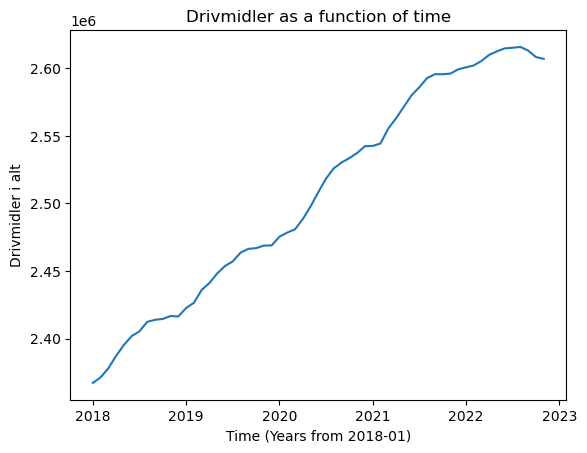

In [3]:

plt.plot(time,list_of_drive)
plt.title('Drivmidler as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.savefig("plot_data.png")

Notes
- Seems to be globally increasing somewhat linearly, stagnates towards the end and seems to be a slight harmonic structure 

# OLS

In [4]:
# calculate the parameters of an OLS regression:

# stack  with a columnn of ones:
data = np.array(list_of_drive)
time_inter = np.vstack((np.ones(len(time)), time.T)).T

# Calculate the parameters:
beta = np.linalg.inv(time_inter.T @ time_inter) @ time_inter.T @ data

In [5]:
beta

array([-109499932.8080861, 55437.78304415987], dtype=object)

In [6]:
# estimate the errors of the parameters:

# calculate the residuals:
residuals = data - time_inter @ beta

# calculate the variance of the residuals:
variance = residuals.T @ residuals / (len(time) - 2)

# calculate the variance of the parameters:
var_beta = variance * np.linalg.inv(time_inter.T @ time_inter)

# calculate the standard deviation of the parameters:
std_beta = np.sqrt(np.diag(var_beta))

std_beta

array([1.92155555e+06, 9.51068713e+02])

In [7]:
# forecaset of the drivmidler 
x_forecase = np.array([np.max(time)+1/12*i for i in range (1, 13)])
x_forecase = np.vstack((np.ones(len(x_forecase)), x_forecase.T)).T
y_forecase = x_forecase @ beta

# calculate the confidence interval:
t = stats.t.ppf(0.90, len(time) - 2)

# calculate the vmatrix based on variance and the x_forecase matrix:
vmatrix = variance * (1+x_forecase @ np.linalg.inv(time_inter.T @ time_inter) @ x_forecase.T)
y_forecase_upper = y_forecase + t * np.sqrt(np.diag(vmatrix))
y_forecase_lower = y_forecase - t * np.sqrt(np.diag(vmatrix))


In [8]:
# load the test data:

data_test=pd.read_excel("DST_BIL54_test.xlsx",header=None)
data_test = data_test.iloc[1].values
data_test = data_test[1:]

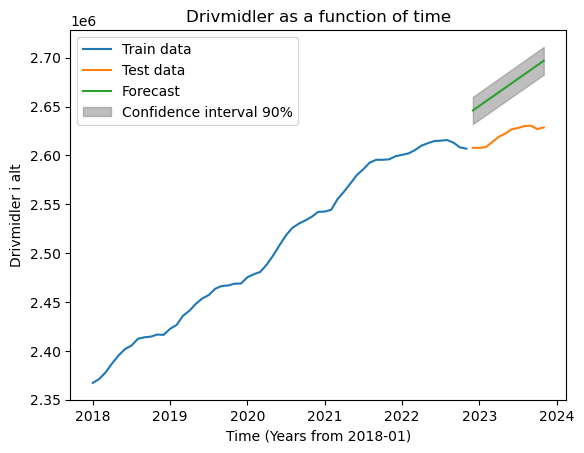

In [9]:
# plot the forecast data with the old data:
x_values = x_forecase[:,1]
plt.plot(time,list_of_drive)
plt.plot(x_values,data_test)
plt.plot(x_values,y_forecase)
plt.fill_between(x_values,list(y_forecase_lower),list(y_forecase_upper), color='gray', alpha=0.5)
plt.legend(["Train data",'Test data','Forecast','Confidence interval 90%'])
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.title('Drivmidler as a function of time')
plt.savefig('forecastOLS.png')


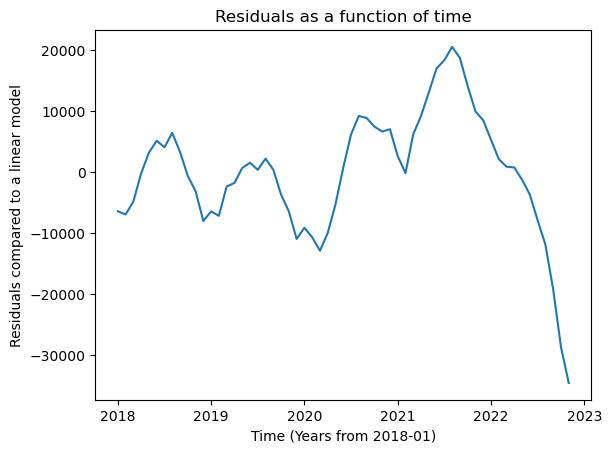

In [10]:
# investigate residuals:
plt.plot(time,residuals)
plt.title('Residuals as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Residuals compared to a linear model')
plt.savefig('residuals.png')

# WLS

We will now use WLS to make the linear model in Eq. (1) as a local trend model, i.e., the observation
at the latest timepoint (xN = x59 = 2022.833) has weight λ0 = 1, the observation at the second
latest timepoint (xN −1 = x58 = 2022.750) has weight λ1 , the third latest observation (xN −2 = x57 =
2022.667) has weight λ2 etc.
We start by setting λ = 0.9.

In [11]:
# Creating the Sigma matrix for WLS
lamb = 0.9
Sigma = np.zeros((len(time),len(time)))
for i in range(len(time)):
    Sigma[i,i] = 1/(lamb**(len(time)-i))


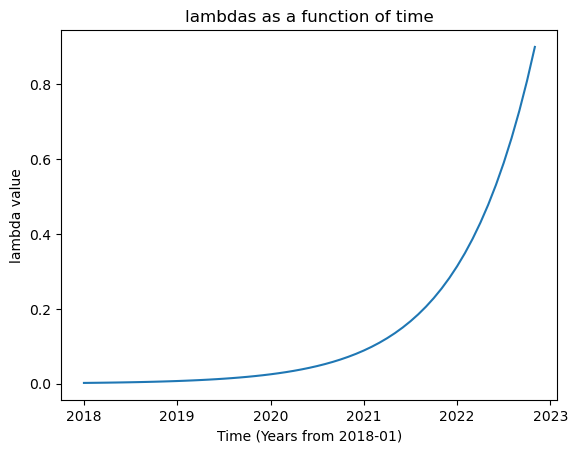

In [12]:
# Plot diagonals as a function of time: 

plt.plot(time,1/np.diag(Sigma))
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('lambda value')
plt.title("lambdas as a function of time")
plt.savefig("WLSLambdasVsTime.png")

In [13]:
np.sum(1/np.diag(Sigma))

8.982029897000858

In [14]:
#calculate the parameters: 

beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
beta_WLS

array([-84089781.034374, 42868.564483606955], dtype=object)

In [15]:
# make prediction: 
y_pred_WLS_09 = x_forecase @ beta_WLS

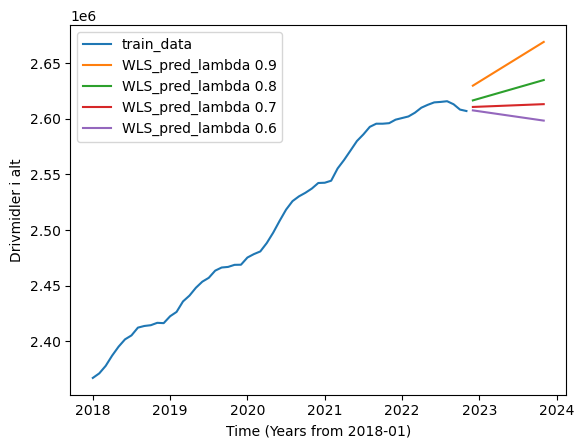

In [16]:
legend = ["train_data"]
plt.plot(time,list_of_drive)
for lamb in  [0.9,0.8,0.7,0.6]:
    Sigma = np.zeros((len(time),len(time)))
    for i in range(len(time)):
        Sigma[i,i] = 1/(lamb**(len(time)-i))
    
    beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
    y_pred_WLS = x_forecase @ beta_WLS
    plt.plot(x_values,y_pred_WLS)
    legend.append(f"WLS_pred_lambda {lamb}")

plt.legend(legend)
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.savefig("WLS_preds_labdas.png")
plt.show()

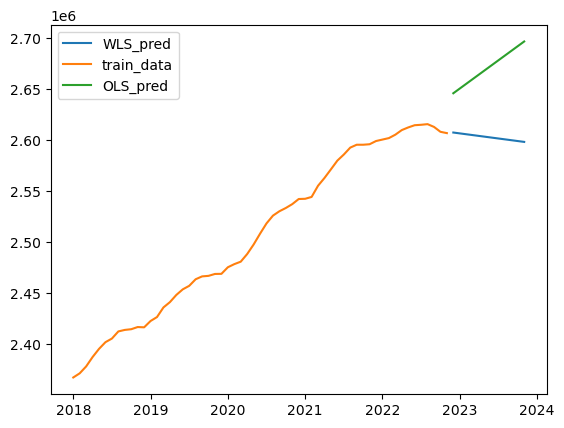

In [17]:

plt.plot(x_values,y_pred_WLS)
plt.plot(time,list_of_drive)
plt.plot(x_values,y_forecase)
plt.legend(["WLS_pred","train_data","OLS_pred"])

# 4 Iterative update and optimal lambda

## 4.1

In [18]:
def f(j):
    return np.array([[1],[j]])

L = np.array([[1,0],[1,1]])

# Inverse of L
Linv = inv(L)

print(L)
print(f(0))

[[1 0]
 [1 1]]
[[1]
 [0]]


## 4.2

In [36]:
# lambda is in both equations, but it is powered to 0, so it becomes 1.
F_1 = f(-0)@f(-0).T

h_1 = f(-0)*data[0]

print(f'F_1 =\n {F_1}\n')
print(f'h_1 = \n {h_1}\n')


F_1 =
 [[1 0]
 [0 0]]

h_1 = 
 [[2367154]
 [      0]]



## 4.3

In [37]:
# Initialize parameters
lambda_ = 0.95

In [56]:
# Initializing F_N and h_N
F_N = F_1
h_N = h_1

for n in range(1,10):
    F_Np1 = F_N + lambda_**n * f(-n)@f(-n).T
    h_Np1 = lambda_ * Linv@h_N + f(0)*data[n]
    
    # Update F_1 and h_1 for next iteration
    F_N = F_Np1
    h_N = h_Np1

    print(f'F_{n+1} =\n {F_N}\n')
    print(f'h_{n+1} = \n {h_N}\n')
    print("\n")    

F_2 =
 [[ 1.95 -0.95]
 [-0.95  0.95]]

h_2 = 
 [[ 4620036.3]
 [-2248796.3]]



F_3 =
 [[ 2.8525 -2.755 ]
 [-2.755   4.56  ]]

h_3 = 
 [[ 6767037.485]
 [-6525390.97 ]]



F_4 =
 [[ 3.709875 -5.327125]
 [-5.327125 12.276375]]

h_4 = 
 [[  8815907.61075]
 [-12627807.03225]]



F_5 =
 [[ 4.52438125 -8.58515   ]
 [-8.58515    25.308475  ]]

h_5 = 
 [[ 10770360.2302125]
 [-20371528.91085  ]]



F_6 =
 [[  5.29816219 -12.45405469]
 [-12.45405469  44.65299844]]

h_6 = 
 [[ 12633658.21870187]
 [-29584794.68400937]]



F_7 =
 [[  6.03325408 -16.86460603]
 [-16.86460603  71.1163065 ]]

h_7 = 
 [[ 14407325.30776678]
 [-40107530.25757568]]



F_8 =
 [[  6.73159137 -21.7529671 ]
 [-21.7529671  105.33483401]]

h_8 = 
 [[ 16099305.04237844]
 [-51789112.78707533]]



F_9 =
 [[  7.39501181 -27.06033055]
 [-27.06033055 147.79374161]]

h_9 = 
 [[ 17708171.79025952]
 [-64493996.93798108]]



F_10 =
 [[  8.02526122 -32.73257524]
 [-32.73257524 198.8439438 ]]

h_10 = 
 [[ 19237285.20074654]
 [-78092060.29182

## 4.4

In [22]:
yhat_Np1_1month  = np.zeros(49)
yhat_Np1_6month  = np.zeros(49)
yhat_Np1_12month = np.zeros(49)

for n in range(10,59):
    F_Np1 = F_N + lambda_**n * f(-n)@f(-n).T
    h_Np1 = lambda_ * Linv@h_N + f(0)*data[n]
    
    # Theta_hat
    thetahat_Np1 = inv(F_Np1)@h_Np1 
    
    # Predictions
    yhat_Np1_1month[n-10] = (f(1).T@thetahat_Np1)[0,0]
    yhat_Np1_6month[n-10] = (f(6).T@thetahat_Np1)[0,0]
    yhat_Np1_12month[n-10] = (f(12).T@thetahat_Np1)[0,0]
    
    # Update F_1 and h_1 for next iteration
    F_N = F_Np1
    h_N = h_Np1

## 4.5

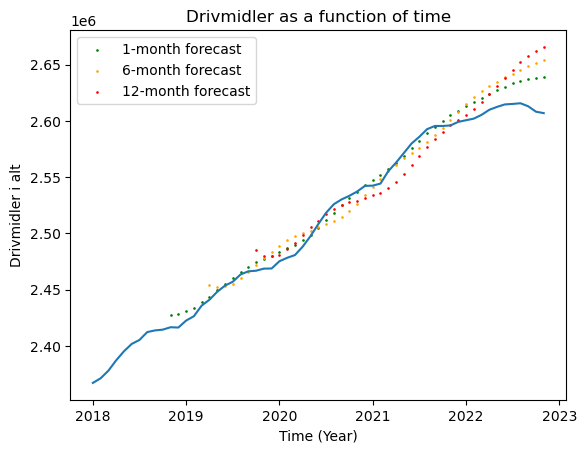

In [27]:
# Plot
plt.scatter(time[10:59],yhat_Np1_1month, s = 0.8, c = 'green', label = '1-month forecast')
plt.scatter(time[15:59],yhat_Np1_6month[0:44], s = 0.8, c = 'orange', label = '6-month forecast')
plt.scatter(time[21:59],yhat_Np1_12month[0:38], s = 0.8, c = 'red', label = '12-month forecast')
plt.plot(time,data)
plt.title('Drivmidler as a function of time')
plt.xlabel('Time (Year)')
plt.ylabel('Drivmidler i alt')
plt.legend()

## 4.6

In [24]:
# Creating np.array with lambdas
lambdas = np.arange(0.55,0.96,0.01)

# Initializing np.arrays for predicted values
yhat_Np1_1month  = np.zeros(49)
yhat_Np1_6month  = np.zeros(49)
yhat_Np1_12month = np.zeros(49)

# Initializing RMSE
RMSE_1month = np.zeros(len(lambdas))
RMSE_6month = np.zeros(len(lambdas))
RMSE_12month = np.zeros(len(lambdas))

for i in range(0,len(lambdas)):
    # Initializing F_N and h_N
    F_N = F_1
    h_N = h_1
    
    # Update FN and hN recursively, predictions are not calculated for the first 10 steps
    for n in range(1,10):
        F_Np1 = F_N + lambdas[i]**n * f(-n)@f(-n).T
        h_Np1 = lambdas[i] * Linv@h_N + f(0)*data[n]

        # Update F_N and h_N for next iteration
        F_N = F_Np1
        h_N = h_Np1
    
    # Update FN and hN recursively for the rest, predictions are now calculated
    for n in range(10,59):
        F_Np1 = F_N + lambdas[i]**n * f(-n)@f(-n).T
        h_Np1 = lambdas[i] * Linv@h_N + f(0)*data[n]

        # Theta_hat
        thetahat_Np1 = inv(F_Np1)@h_Np1 

        # Predictions
        yhat_Np1_1month[n-10] = (f(1).T@thetahat_Np1)[0,0]
        yhat_Np1_6month[n-10] = (f(6).T@thetahat_Np1)[0,0]
        yhat_Np1_12month[n-10] = (f(12).T@thetahat_Np1)[0,0]

        # Update F_1 and h_1 for next iteration
        F_N = F_Np1
        h_N = h_Np1
    
    # Calculating RMSE
    RMSE_1month[i]  = np.sqrt(np.mean((data[10:59] - yhat_Np1_1month)**2))
    RMSE_6month[i]  = np.sqrt(np.mean((data[15:59] - yhat_Np1_6month[0:44])**2))
    RMSE_12month[i] = np.sqrt(np.mean((data[21:59] - yhat_Np1_12month[0:38])**2))

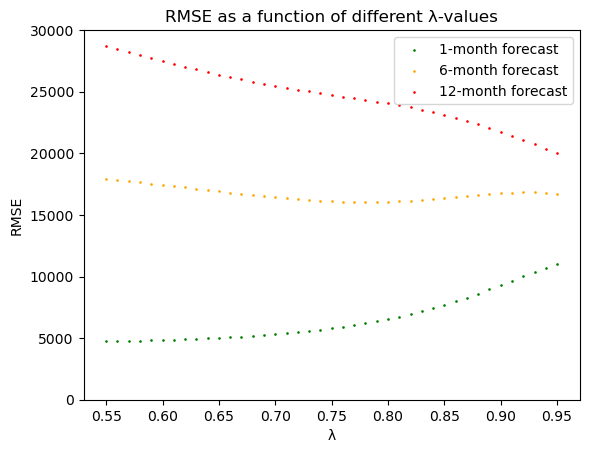

In [31]:
# Plot
plt.scatter(lambdas,RMSE_1month, s = 0.8, c = 'green', label = '1-month forecast')
plt.scatter(lambdas,RMSE_6month, s = 0.8, c = 'orange', label = '6-month forecast')
plt.scatter(lambdas,RMSE_12month, s = 0.8, c = 'red', label = '12-month forecast')
plt.title('RMSE as a function of different λ-values')
plt.xlabel('λ')
plt.ylabel('RMSE')
plt.ylim(0,30000)
plt.legend()